# Transfer Learning for image data using CNN

# Unzip and load the dataset

In [1]:
!unzip /data.zip

Archive:  /data.zip
replace data/chicken-images/test/0U5DJ4AHL7U8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Import necessary libraries

In [2]:
import os, sys, random, time, copy, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, f1_score

from PIL import Image

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from tempfile import TemporaryDirectory

warnings.filterwarnings("ignore")

# Set up the data for training

## Path to Chicken and Duck Images

In [3]:
CHICKEN_IMAGES_PATH = "/content/data/chicken-images/"
DUCK_IMAGES_PATH = "/content/data/duck-images/"

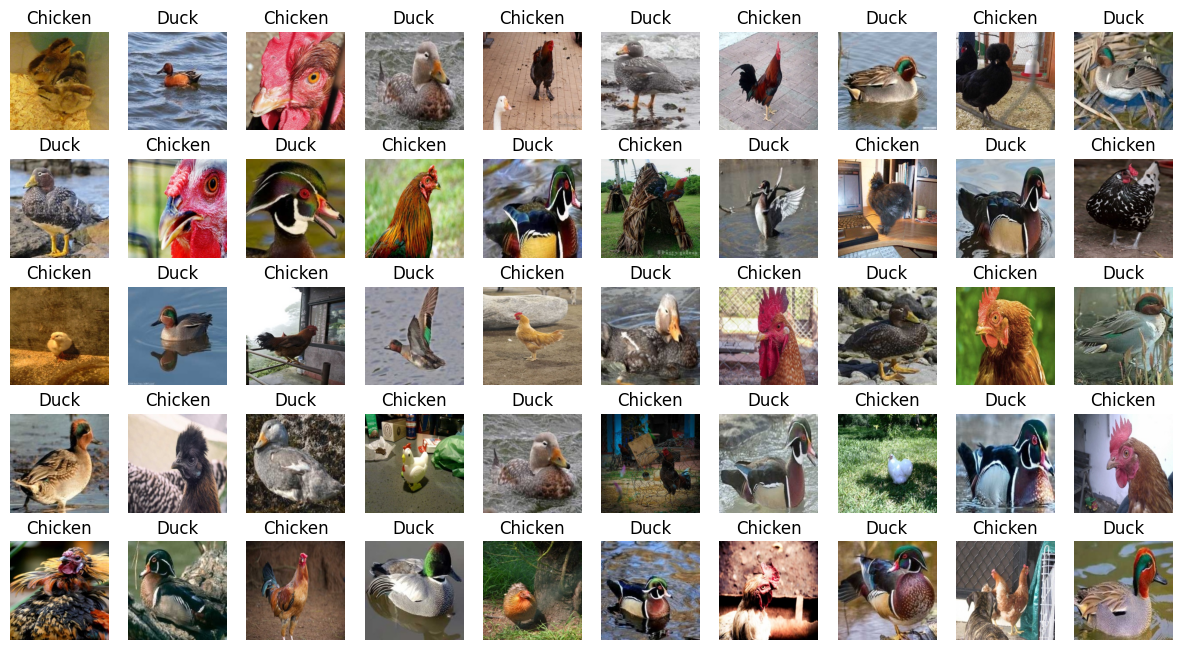

In [4]:
chicken_images_dir = glob.glob(f"{CHICKEN_IMAGES_PATH}/train/*")
duck_images_dir = glob.glob(f"{DUCK_IMAGES_PATH}/train/*")

random.seed(7)

chicken = random.sample(chicken_images_dir, k = 25)
duck = random.sample(duck_images_dir, k = 25)

fig, ax = plt.subplots(5, 10, figsize=(15, 8))
for i in range(5):
  for j in range(10):
    if (i+j)%2 == 0:
      ax[i,j].imshow(Image.open(chicken[0]))
      chicken.pop(0)
      ax[i,j].axis("off")
      ax[i,j].set_title("Chicken")
    else:
      ax[i,j].imshow(Image.open(duck[0]))
      duck.pop(0)
      ax[i,j].axis("off")
      ax[i,j].set_title("Duck")
plt.show()

## Create annotations

In [5]:
def create_annotations_file(paths: list[str]):
    # training dataset
    train = pd.DataFrame(columns=["path", "class"])
    for path in paths:
        full_path = os.path.join(path, "train")
        image_names = [f"{path}/train/{_}" for _ in os.listdir(full_path)]
        label = path.split("/")[3]
        temp = pd.DataFrame({"path": image_names, "class": label})
        train = pd.concat([train, temp])

    # validation dataset
    val = pd.DataFrame(columns=["path", "class"])
    for path in paths:
        full_path = os.path.join(path, "val")
        image_names = [f"{path}/val/{_}" for _ in os.listdir(full_path)[:50]]
        label = path.split("/")[3]
        temp = pd.DataFrame({"path": image_names, "class": label})
        val = pd.concat([val, temp])

    # test dataset
    test = pd.DataFrame(columns=["path", "class"])
    for path in paths:
        full_path = os.path.join(path, "test")
        image_names = [f"{path}/test/{_}" for _ in os.listdir(full_path)[:100]]
        label = path.split("/")[3]
        temp = pd.DataFrame({"path": image_names, "class": label})
        test = pd.concat([test, temp])

    train = train.reset_index(drop=True)
    val = val.reset_index(drop=True)
    test = test.reset_index(drop=True)

    return train, val, test


## Get the training, validation and test data

In [6]:
train, val, test = create_annotations_file([CHICKEN_IMAGES_PATH, DUCK_IMAGES_PATH])

In [7]:
class ChickenOrDuck(Dataset):

    def __init__(
        self, annotations_file, transforms=transforms.Compose([transforms.ToTensor()])
    ):
        super().__init__()
        self.annotations_file = annotations_file
        self.transforms = transforms

    def __getitem__(self, index):
        image_path = self.annotations_file.loc[index, "path"]
        image_class = self.annotations_file.loc[index, "class"]
        image_label = 1 if image_class == "chicken-images" else 0

        image = Image.open(image_path).convert("RGB")
        image = image.resize((256, 256))
        image = self.transforms(image)

        return image, image_label

    def __len__(self):
        return len(self.annotations_file)

## Preprocess the data

In [8]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # Image Net mean and std

image_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    ),
}


## Load the datasets

In [9]:
train_dataset = ChickenOrDuck(train, image_transforms["train"])
val_dataset = ChickenOrDuck(val, image_transforms["val"])
test_dataset = ChickenOrDuck(test, image_transforms["val"])

## Set up device and Batch size

In [10]:
BATCH_SIZE = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
print(device)

cuda


In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Number of Batches and Total number of images

Number of batches

In [13]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(29, 5, 10)

Number of images in train, val and test data

In [14]:
val_size = len(val_dataset)
train_size = len(train_dataset)
test_size = len(test_dataset)

In [15]:
train_size, val_size, test_size

(576, 100, 198)

# Function for training the model

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode

                    running_loss = 0.0
                    running_corrects = 0

                    for inputs, labels in train_dataloader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            loss.backward()
                            optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                        scheduler.step()

                    epoch_loss = running_loss / train_size
                    epoch_acc = float(running_corrects) / train_size

                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                else:
                    model.eval()   # Set model to evaluate mode

                    running_loss = 0.0
                    running_corrects = 0

                    # Iterate over data.
                    for inputs, labels in val_dataloader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                        scheduler.step()


                    epoch_loss = running_loss / val_size
                    epoch_acc = float(running_corrects) / val_size

                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

# Load the pretrained model - Resnet18

## Adjust the final layer and set up loss function and optimizer

In [17]:
model_ft = resnet18(weights = ResNet18_Weights)

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Fit the model

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 1/10
----------
train Loss: 0.5517 Acc: 0.7691
val Loss: 0.4572 Acc: 0.9100
Epoch 2/10
----------
train Loss: 0.4758 Acc: 0.8750
val Loss: 0.4563 Acc: 0.9100
Epoch 3/10
----------
train Loss: 0.4730 Acc: 0.8819
val Loss: 0.4580 Acc: 0.9100
Epoch 4/10
----------
train Loss: 0.4769 Acc: 0.8698
val Loss: 0.4601 Acc: 0.9000
Epoch 5/10
----------
train Loss: 0.4760 Acc: 0.8646
val Loss: 0.4554 Acc: 0.9100
Epoch 6/10
----------
train Loss: 0.4673 Acc: 0.8924
val Loss: 0.4554 Acc: 0.9100
Epoch 7/10
----------
train Loss: 0.4716 Acc: 0.8837
val Loss: 0.4582 Acc: 0.9100
Epoch 8/10
----------
train Loss: 0.4674 Acc: 0.8906
val Loss: 0.4564 Acc: 0.9100
Epoch 9/10
----------
train Loss: 0.4675 Acc: 0.9045
val Loss: 0.4582 Acc: 0.9000
Epoch 10/10
----------
train Loss: 0.4733 Acc: 0.8872
val Loss: 0.4574 Acc: 0.9100
Training complete in 0m 48s
Best val Acc: 0.910000


# Classification Report

In [19]:
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

# Get predictions for the test set
predictions, true_labels = get_predictions(model_ft, test_dataloader, device)

# Generate the classification report
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.88      0.94      0.91        98
           1       0.94      0.88      0.91       100

    accuracy                           0.91       198
   macro avg       0.91      0.91      0.91       198
weighted avg       0.91      0.91      0.91       198



Here `Chicken = 1` and `Duck = 0`